In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as stats

import code_support

from sklearn.cluster import DBSCAN, KMeans, MeanShift
from sklearn.neighbors import NearestNeighbors as nn
from sklearn.metrics import pairwise_distances
import sklearn

In [2]:
%matplotlib inline
for n_neighbours in range(2, 12):
    nbrs = nn(n_neighbors=n_neighbours+1, algorithm='ball_tree').fit(points_xyz)
    dist, ind = nbrs.kneighbors(points_xyz)
    dist_to_nneighbor = dist[:,n_neighbours]

    dist_to_nneighbor.sort()
    fragment = dist_to_nneighbor[:]
    
    
    fig = plt.figure(figsize=(10, 6))
    plt.yticks(np.linspace(0, 1.0, 20))
    num = plt.hist(fragment, bins=100,  cumulative=True, density=True)
    plt.title("n_neighbours {0}".format(n_neighbours))
    plt.grid(True)
    plt.show()
    #%matplotlib inline

NameError: name 'points_xyz' is not defined

### KMean

In [25]:
k_means = KMeans(n_clusters=1)
res = k_means.fit(points_xyz)
cen = res.cluster_centers_

In [26]:
cen.T

array([[ 7939.27878992],
       [ 3073.69789383],
       [ 2711.71730961]])

### DBSCAN

In [2]:
def do_scan(points_xyz, n_neighbors, eps, verbose=False):
    #n_neighbours = 6
    #eps = 1400
    num_clusters_inter = 4
    
    dbscan = DBSCAN(eps=eps, min_samples=n_neighbours+1).fit(points_xyz)
    cen_dbscan = points_xyz[dbscan.labels_==0].mean(axis=0)

    clusters = list()
    cen_clusters = list()

    labels, count_labels = np.unique(dbscan.labels_, return_counts=True)
    most_freq_labels = labels[np.argsort(count_labels)[::-1][:num_clusters_inter]]

    for lab in most_freq_labels:
        if lab == -1:
            continue
        clusters.append(points_xyz[dbscan.labels_==lab])    
        cen_clusters.append(clusters[-1].mean(axis=0))
        if verbose:
            print('for label', lab, 'there are', clusters[-1].shape[0], 'galaxies')
    
    noize = points_xyz[dbscan.labels_==-1]
    if verbose:
        print('noize num : ', noize.shape)

    return clusters, cen_clusters, noize, dbscan.labels_

In [32]:
dir_path = 'data/Abell less 0.3/'
ra_dec = list()
j = 0
j1 = 0

for i in range(1, 2714):
    name_file = 'Abell_g_less_0.3 ' + str(i) + '.txt'
    full_path = dir_path + name_file
    try:
        data = code_support.reader(full_path, skip_lines=0)
        if data.shape == (0,):
            j1+=1
            continue
        ra = np.median(data[:,0])
        dec = np.median(data[:, 1])
        ra_dec.append([ra, dec])
    except IOError:
        j+=1
    
    

In [36]:
ra_dec = np.array(ra_dec)

In [41]:
ra_dec[(ra_dec[:, 0] < 66) | (ra_dec[:, 0] > 306)].shape

(507, 2)

In [43]:
ra_dec.shape

(1861, 2)

In [580]:
dir_path = 'data/Abell less 0.3 chosen/'
list_nums = list()

coef_hugest_cluster = 0.4
coef_2_clusters = 0.3
coef_1st_to_2nd = 0.25


all_clusters = list()
not_big = 0
two_small = 0
not_big_70 = 0
bad_alg = 0
two_clusters = 0
bad_cluster = 0 

for i in range(1, 2714):
    name_file = 'Abell_' + str(i) + ' less 0.3 chosen.txt'
    full_path = dir_path + name_file
    try:
        data = code_support.reader(full_path, skip_lines=1)
        list_nums.append(data.shape[0])
    except IOError:
        continue
    
    points_xyz, ray = get_one(full_path)
    num_galaxies = points_xyz.shape[0]
    
    if num_galaxies < 40:
        continue
    pair_dist = pairwise_distances(points_xyz)
    not_zero_pair = np.triu(pair_dist)

    med = np.median(not_zero_pair[not_zero_pair!=0])
    
    #print(num_galaxies)
    
    if num_galaxies > 100:
        clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=5, eps=med*0.25)
    
    else:
        clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=3, eps=med*0.2)
    
    if len(clusters) == 0:
        bad_alg += 1
        clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=2, eps=med*0.1)
        if len(clusters) == 0:
            bad_cluster += 1
            all_clusters.append(points_xyz.mean(axis=0))
            continue
    
    num_bigest = clusters[0].shape[0]
    
    
    if len(clusters) == 1:
        num_second = 0
    else:
        num_second = clusters[1].shape[0]
    
    
    
    if num_galaxies > 100:
        if (num_bigest-num_second)/num_bigest < coef_1st_to_2nd:
            if num_bigest > coef_2_clusters:
                all_clusters.append(cen_clusters[0])
                all_clusters.append(cen_clusters[1])
                two_clusters += 1
            else:
                 two_small += 1
        elif num_bigest/num_galaxies > coef_hugest_cluster:
            all_clusters.append(cen_clusters[0])
        
        else:
            not_big += 1
    
    elif num_bigest/num_galaxies > coef_hugest_cluster:
        all_clusters.append(cen_clusters[0])
        
    else:
        not_big_70 += 1
        all_clusters.append(points_xyz.mean(axis=0))
    
    
arr_clusters = np.array(all_clusters)
pair_dist_clusters = pairwise_distances(arr_clusters)
not_zero_pair = np.triu(pair_dist_clusters)
not_zero_pair = not_zero_pair[not_zero_pair!=0]
arr_clusters.shape
to_del = np.unique(np.argwhere((pair_dist_clusters<2) & (pair_dist_clusters>0)).flatten())
arr_clusters = np.delete(arr_clusters, to_del, 0)
num = plt.hist(not_zero_pair, bins=800)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=r

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=r

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=r

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=r

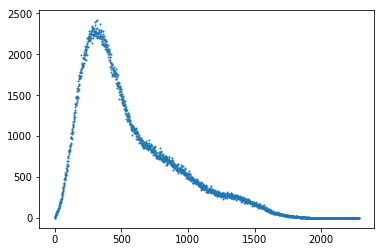

In [586]:
%matplotlib inline

n1 = np.histogram(not_zero_pair, bins=2000)
plt.scatter(n1[1][1:], n1[0], s=1)
plt.show()

In [421]:
def get_one(full_path, print_points=False):
    points = code_support.reader(full_path, skip_lines=1)
    ray = np.zeros((3,))
    #print(points.shape)
    if print_points:
        print(np.max(points[:,0]) - np.min(points[:,0]))
        print(np.max(points[:,1]) - np.min(points[:,1]))
        print(np.max(points[:,0]))
        print('dec')
        print(np.min(points[:,1]))
        print(np.max(points[:,1]))
        #print(points)
        #for point in points:
            #print(point)
    ray = np.array([np.max(points[:,0])-(np.max(points[:,0]) - np.min(points[:,0]))/2, 
                    np.max(points[:,1])-(np.max(points[:,1]) - np.min(points[:,1]))/2, 
                    np.max(points[:,2])])
    points = np.vstack((points, ray))
    coef_scale = 300000.0 / 66.93
    cos_dec = np.cos(points[:,1]*np.pi/180.0)
    sin_dec = np.sin(points[:,1]*np.pi/180.0)
    
    cos_ra = np.cos(points[:,0]*np.pi/180.0)
    sin_ra = np.sin(points[:,0]*np.pi/180.0)
    
    r = points[:,2]
    points_xyz = np.zeros_like(points)
    points_xyz[:,0] = r * cos_dec * cos_ra
    points_xyz[:,1] = r * cos_dec * sin_ra
    points_xyz[:,2] = r * sin_dec 
    points_xyz *= coef_scale
    
    return points_xyz[:-1,:], points_xyz[-1,:]

In [565]:
dir_path = 'data/Abell less 0.3 chosen/'
name_file = 'Abell_8 less 0.3 chosen.txt'

#dir_path = 'data/Abell less 0.3/'
#name_file = 'Abell_g_less_0.3 3.txt'
full_path = dir_path + name_file
points_xyz, ray = get_one(full_path)
print(points_xyz.shape)

(234, 3)


(455, 3)
max = 1332.073
mediana = 270.73776954646416
for label 0 there are 276 galaxies
for label 2 there are 60 galaxies
for label 4 there are 35 galaxies
noize num :  (24, 3)


<IPython.core.display.Javascript object>


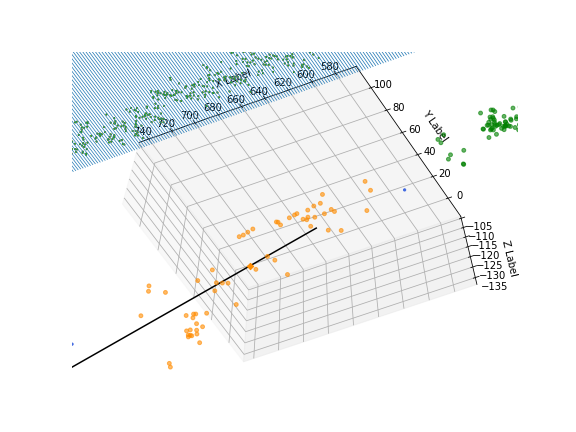

0
1
2


In [574]:
#dir_path = 'data/Abell less 0.3 chosen/'
#name_file = 'Abell_9 less 0.3 chosen.txt'

dir_path = 'data/Abell less 0.3/'
name_file = 'Abell_g_less_0.3 8.txt'

full_path = dir_path + name_file
points_xyz, ray = get_one(full_path)
print(points_xyz.shape)


pair_dist = pairwise_distances(points_xyz)
not_zero_pair = np.triu(pair_dist)
print("max = {0:.3f}".format(np.max(not_zero_pair[not_zero_pair!=0])))

med = np.median(not_zero_pair[not_zero_pair!=0])
print("mediana = {0}".format(med))

clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=5, eps=med/8, verbose=True)
%matplotlib notebook
fig = plt.figure(figsize=(8,6))
colours = ['royalblue', 'green', 'darkorange', 'purple']
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(0, 0, 0, c='black', s=20)
ax.plot([ray[0]/2, ray[0]], [ray[1]/2, ray[1]], [ray[2]/2, ray[2]], c='black')
for i, cluster in enumerate(clusters):
    print(i)
    if i >= 3:
        break
    ax.scatter(*(cluster.T), c=colours[i+1], s=15, alpha=0.6)
    ax.scatter((*cen_clusters[i]), c=colours[i+1], s=20, marker='D') 
ax.scatter(*(noize.T), c=colours[0], s=5, alpha=1)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.set_zticks([])
#plt.xticks([], [])
#plt.yticks([], [])

plt.axis('equal')
#plt.gca().set_aspect('equal', adjustable='box')
#ax.set_zlim(10, 500)
plt.grid('True')
plt.show()


In [584]:
%matplotlib


Using matplotlib backend: nbAgg


In [3]:
all_03 = code_support.reader('data/raw/0_03_Space.txt')
all_03 = (all_03[all_03[:,2]>10e-3])
all_03 = all_03[(all_03[:,0] < 65) | (all_03[:,0] > 109)]

all_03.shape

(938807, 3)

In [5]:
mask_left = ((all_03[:,0] < 270) & (all_03[:,0] > 102))
left_area = all_03[mask_left] 
right_area = all_03[~mask_left]

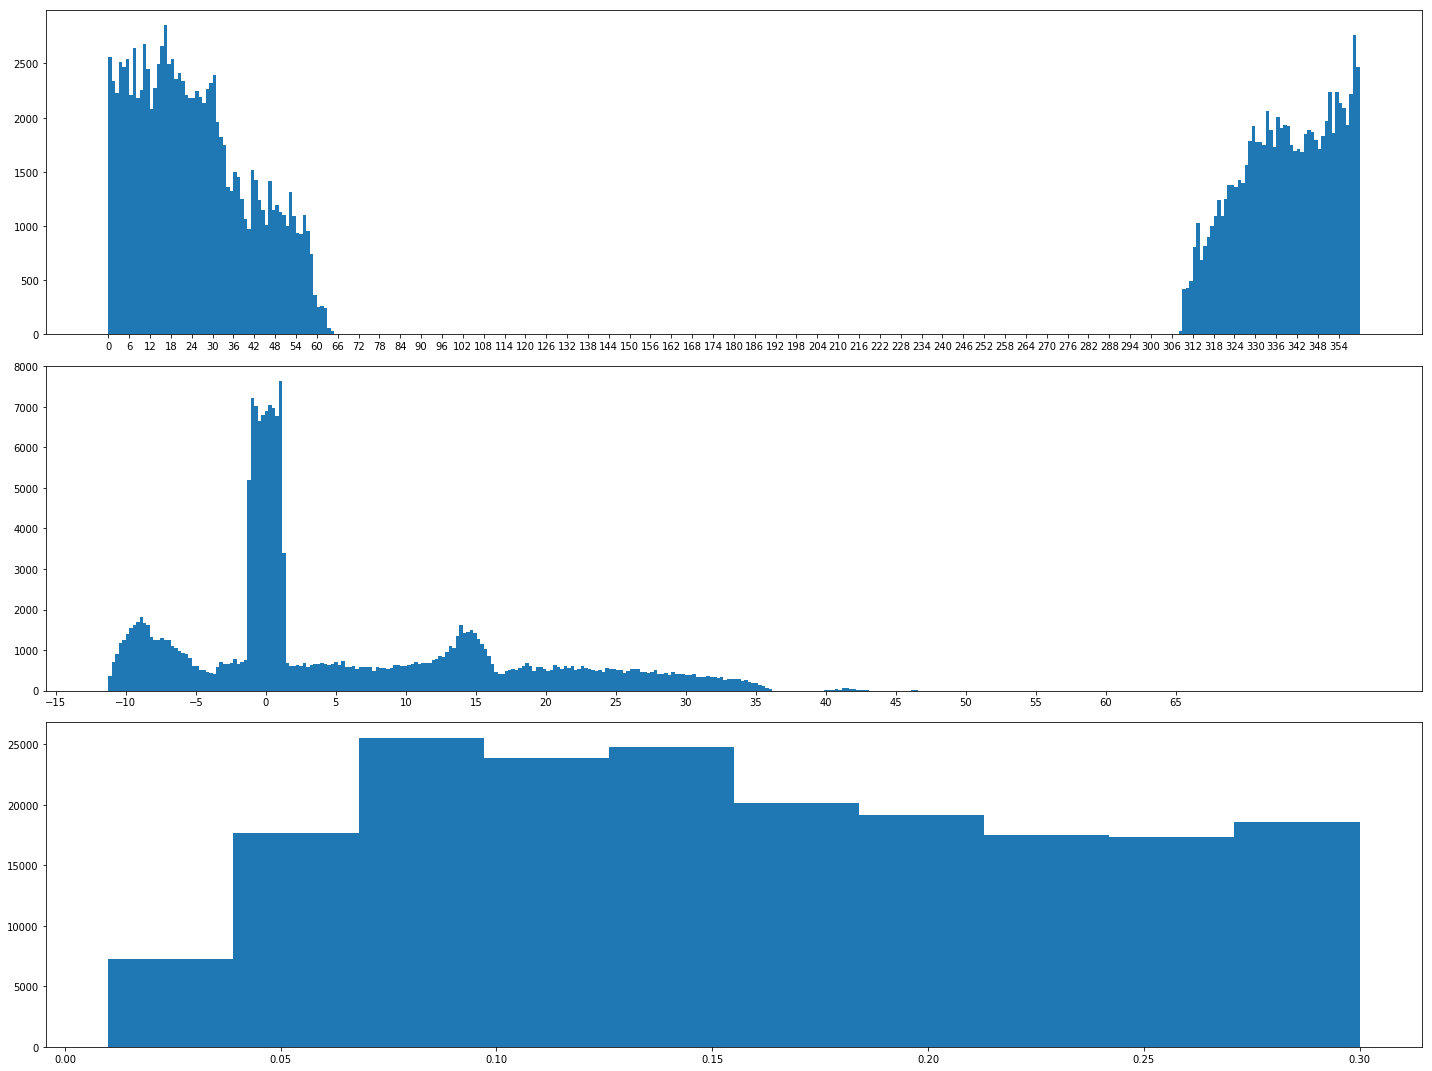

In [6]:
fig = plt.figure(figsize=(20, 15))

data = right_area
ax = plt.subplot(3, 1, 1)
plt.hist(data[:,0], bins=360)
plt.xticks(range(0, 360, 6))

ax = plt.subplot(3, 1, 2)
plt.hist(data[:,1], bins=360)
plt.xticks(range(-15, 70, 5))

ax = plt.subplot(3, 1, 3)
plt.hist(data[:,2])
#plt.xticks(range(-15, 70, 5))
    
    
plt.tight_layout()

In [8]:
def to_xyz(polar_points):
    points = polar_points
    coef_scale = 300000.0 / 66.93
    cos_dec = np.cos(points[:,1]*np.pi/180.0)
    sin_dec = np.sin(points[:,1]*np.pi/180.0)
    
    cos_ra = np.cos(points[:,0]*np.pi/180.0)
    sin_ra = np.sin(points[:,0]*np.pi/180.0)
    
    r = points[:,2]
    points_xyz = np.zeros_like(points)
    points_xyz[:,0] = r * cos_dec * cos_ra
    points_xyz[:,1] = r * cos_dec * sin_ra
    points_xyz[:,2] = r * sin_dec 
    points_xyz *= coef_scale
    return points_xyz

In [9]:
points_xyz = to_xyz(right_area)

In [675]:
%matplotlib

Using matplotlib backend: nbAgg


In [10]:
def func_distr(points, n_neighbors):
    nbrs = nn(n_neighbors=n_neighbors+1, algorithm='ball_tree').fit(points)
    dist, ind = nbrs.kneighbors(points)
    dist_to_nneighbor = dist[:,n_neighbors]   
    return dist, ind

In [78]:
n_neighbors = 10
dist, ind = func_distr(points_xyz, n_neighbors)

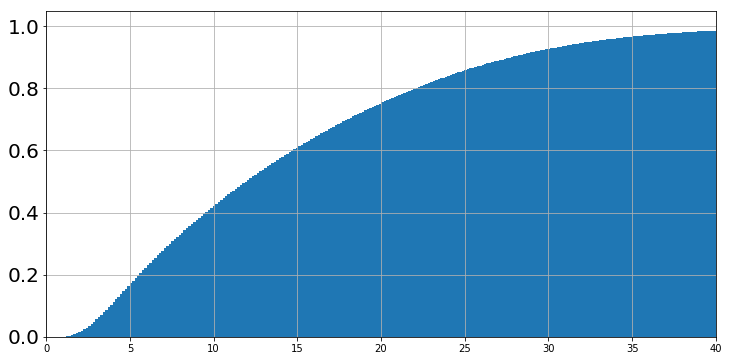

In [153]:
%matplotlib inline    

fig = plt.figure(figsize=(12, 6))
plt.yticks(fontsize=20)
num = plt.hist(dist_to_nneighbor, 5000, cumulative=True, density=True)
#plt.scatter(num[1][1:], num[0], s=1)

plt.xlim(0, 40)
plt.grid(True)

In [11]:
def do_scan_reg(points_xyz, eps, n_neighbors,
                c_very_small=20, c_small=50, c_huge=300):
    dbscan_model = DBSCAN(eps=eps, min_samples=n_neighbors+1, metric='euclidean', algorithm='ball_tree')
    res = dbscan_model.fit_predict(points_xyz)
    lab, counts = np.unique(res, return_counts=True)
    
    noize = counts[0]
    counts = counts[1:]
    very_small = counts[counts<c_very_small].shape[0]
    small = counts[counts<c_small].shape[0] - very_small
    good = counts[(counts<c_huge) & (counts>c_small)].shape[0]
    huge = counts[counts>c_huge].shape[0]
    
    print('noize/all = {0:.3f}'.format(noize/points_xyz.shape[0]))
    print('under {0}: {1}'.format(c_very_small, very_small))
    print('under {0}: {1}'.format(c_small, small))
    print('more {0}: {1}'.format(c_huge, huge))      
    print('bigest cluster: {0}'.format(max(counts)))
    print('good clusters: {0}'.format(good))
    return res, lab, counts
    

n_neighbors = 3 ------ eps = 10
noize/all = 0.226
under 20: 4500
under 50: 345
more 300: 11
bigest cluster: 90110
good clusters: 127


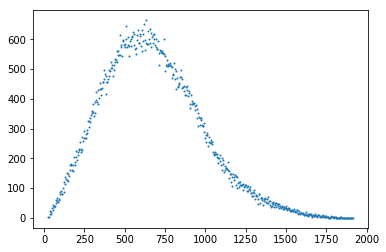



n_neighbors = 4 ------ eps = 8
noize/all = 0.381
under 20: 3225
under 50: 355
more 300: 19
bigest cluster: 54020
good clusters: 146


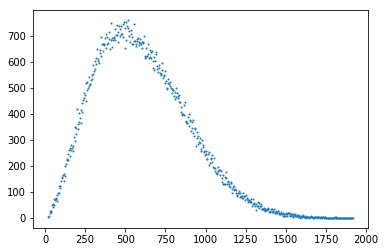



n_neighbors = 6 ------ eps = 4
noize/all = 0.747
under 20: 1320
under 50: 292
more 300: 15
bigest cluster: 3079
good clusters: 139


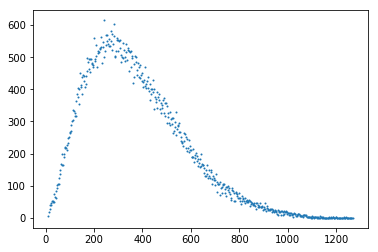

In [246]:
for n_neighbors, eps in [[3, 10], [4, 8], [6, 4]]:
    print('n_neighbors = {0} ------ eps = {1}'.format(n_neighbors, eps))
    res, lab, counts = do_scan_reg(points_xyz, eps, n_neighbors)
    plot_hist_dist(points_xyz, res, lab, counts)
    print('\n')

n_neighbors = 2 ------ eps = 3
noize/all = 0.644
under 20: 8091
under 50: 299
more 300: 11
bigest cluster: 1430
good clusters: 120


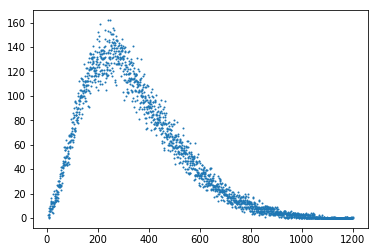



n_neighbors = 2 ------ eps = 4
noize/all = 0.534
under 20: 8751
under 50: 363
more 300: 23
bigest cluster: 3795
good clusters: 157


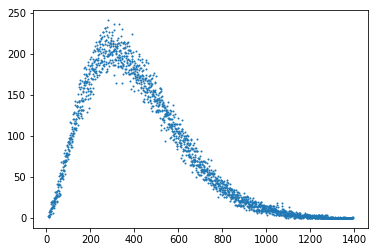



n_neighbors = 2 ------ eps = 5
noize/all = 0.442
under 20: 9047
under 50: 413
more 300: 25
bigest cluster: 14087
good clusters: 171


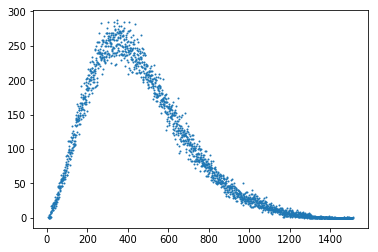



n_neighbors = 2 ------ eps = 6
noize/all = 0.366
under 20: 9039
under 50: 394
more 300: 26
bigest cluster: 24789
good clusters: 176


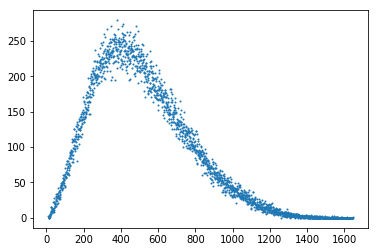



n_neighbors = 2 ------ eps = 7
noize/all = 0.301
under 20: 8836
under 50: 377
more 300: 24
bigest cluster: 31129
good clusters: 165


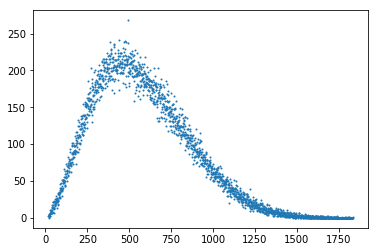



n_neighbors = 2 ------ eps = 8
noize/all = 0.248
under 20: 8279
under 50: 394
more 300: 20
bigest cluster: 63134
good clusters: 136


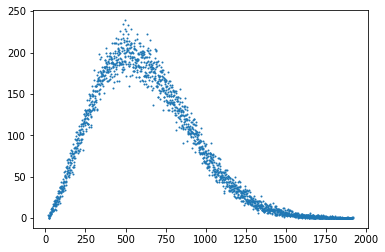



n_neighbors = 2 ------ eps = 9
noize/all = 0.205
under 20: 7678
under 50: 375
more 300: 13
bigest cluster: 80945
good clusters: 131


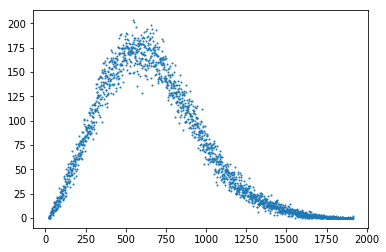



n_neighbors = 2 ------ eps = 10
noize/all = 0.170
under 20: 6893
under 50: 343
more 300: 10
bigest cluster: 92507
good clusters: 144


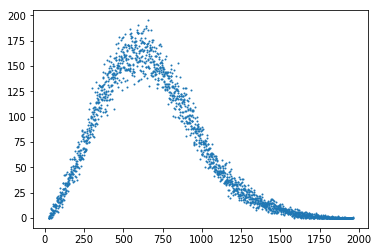



n_neighbors = 2 ------ eps = 11
noize/all = 0.140
under 20: 6109
under 50: 339
more 300: 10
bigest cluster: 102416
good clusters: 137


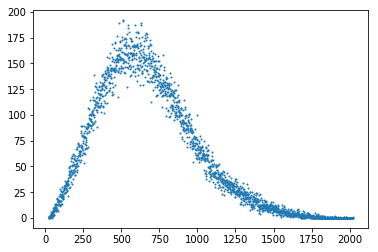



n_neighbors = 2 ------ eps = 12
noize/all = 0.115
under 20: 5414
under 50: 345
more 300: 9
bigest cluster: 111915
good clusters: 127


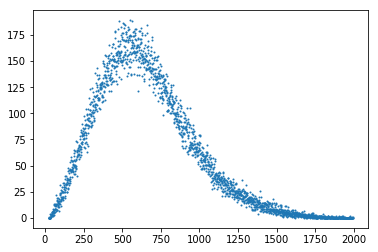



n_neighbors = 2 ------ eps = 13
noize/all = 0.094
under 20: 4687
under 50: 348
more 300: 6
bigest cluster: 120768
good clusters: 115


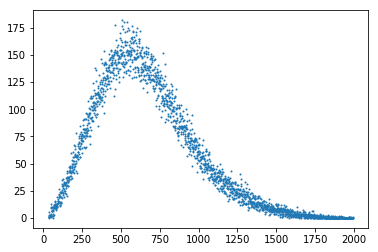



n_neighbors = 2 ------ eps = 14
noize/all = 0.077
under 20: 3935
under 50: 339
more 300: 9
bigest cluster: 128537
good clusters: 115


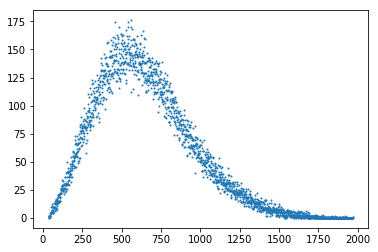



n_neighbors = 3 ------ eps = 3
noize/all = 0.721
under 20: 4156
under 50: 276
more 300: 11
bigest cluster: 1428
good clusters: 113


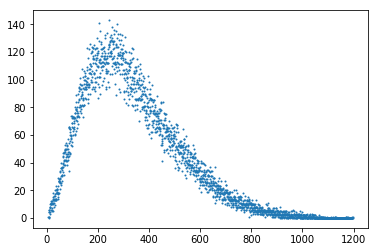



n_neighbors = 3 ------ eps = 4
noize/all = 0.618
under 20: 4505
under 50: 342
more 300: 23
bigest cluster: 3198
good clusters: 156


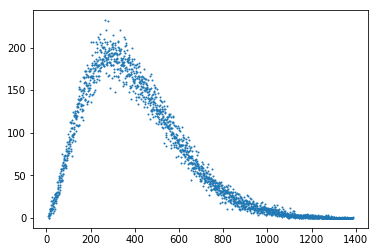



n_neighbors = 3 ------ eps = 5
noize/all = 0.527
under 20: 4820
under 50: 378
more 300: 27
bigest cluster: 13436
good clusters: 166


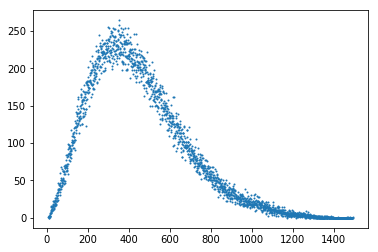



n_neighbors = 3 ------ eps = 6
noize/all = 0.448
under 20: 5022
under 50: 376
more 300: 24
bigest cluster: 23647
good clusters: 178


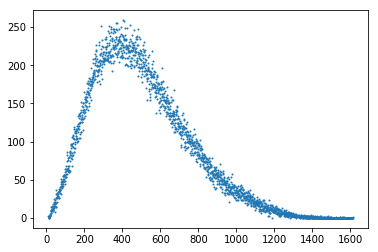



n_neighbors = 3 ------ eps = 7
noize/all = 0.380
under 20: 5096
under 50: 372
more 300: 26
bigest cluster: 29434
good clusters: 161


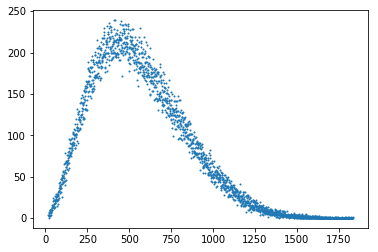



n_neighbors = 3 ------ eps = 8
noize/all = 0.320
under 20: 5042
under 50: 375
more 300: 18
bigest cluster: 59643
good clusters: 144


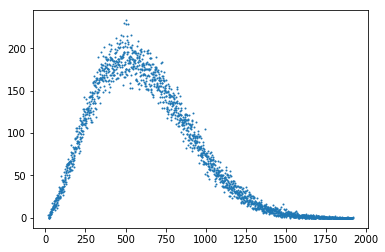



n_neighbors = 3 ------ eps = 9
noize/all = 0.270
under 20: 4782
under 50: 374
more 300: 16
bigest cluster: 76385
good clusters: 124


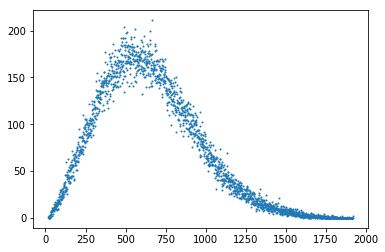



n_neighbors = 3 ------ eps = 10
noize/all = 0.226
under 20: 4500
under 50: 345
more 300: 11
bigest cluster: 90110
good clusters: 127


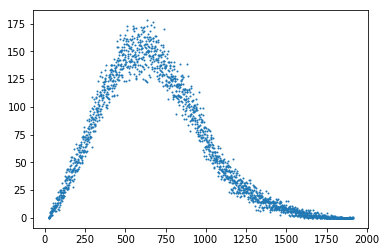



n_neighbors = 3 ------ eps = 11
noize/all = 0.189
under 20: 4050
under 50: 342
more 300: 12
bigest cluster: 98729
good clusters: 142


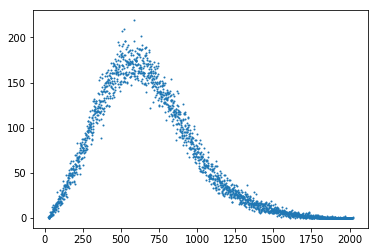



n_neighbors = 3 ------ eps = 12
noize/all = 0.159
under 20: 3637
under 50: 337
more 300: 12
bigest cluster: 107692
good clusters: 133


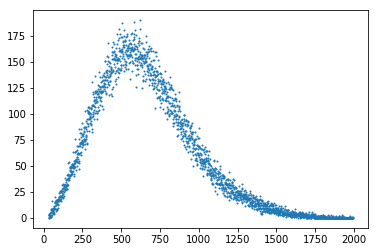



n_neighbors = 3 ------ eps = 13
noize/all = 0.132
under 20: 3251
under 50: 329
more 300: 8
bigest cluster: 116923
good clusters: 119


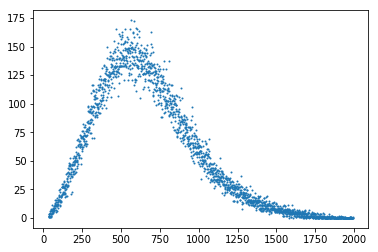



n_neighbors = 3 ------ eps = 14
noize/all = 0.109
under 20: 2785
under 50: 336
more 300: 8
bigest cluster: 126049
good clusters: 122


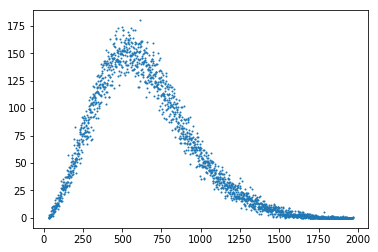



n_neighbors = 4 ------ eps = 3
noize/all = 0.771
under 20: 2487
under 50: 250
more 300: 10
bigest cluster: 996
good clusters: 110


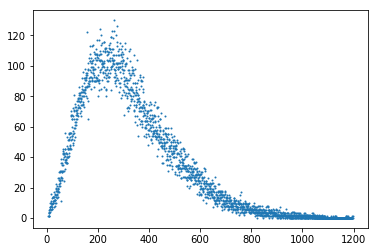



n_neighbors = 4 ------ eps = 4
noize/all = 0.674
under 20: 2741
under 50: 323
more 300: 21
bigest cluster: 3194
good clusters: 150


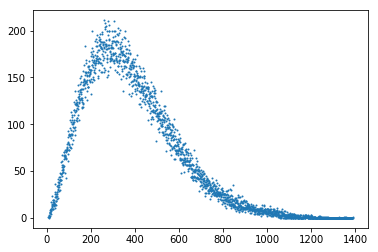



n_neighbors = 4 ------ eps = 5
noize/all = 0.588
under 20: 2907
under 50: 370
more 300: 26
bigest cluster: 12848
good clusters: 161


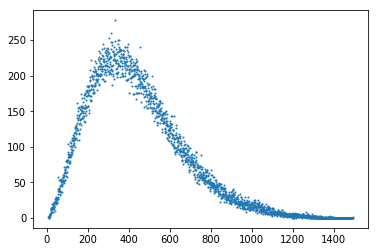



n_neighbors = 4 ------ eps = 6
noize/all = 0.512
under 20: 3021
under 50: 378
more 300: 24
bigest cluster: 18890
good clusters: 176


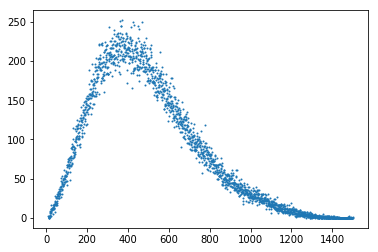



n_neighbors = 4 ------ eps = 7
noize/all = 0.443
under 20: 3171
under 50: 339
more 300: 22
bigest cluster: 28928
good clusters: 167


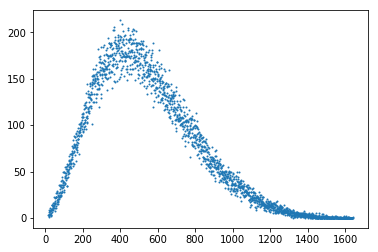



n_neighbors = 4 ------ eps = 8
noize/all = 0.381
under 20: 3225
under 50: 355
more 300: 19
bigest cluster: 54020
good clusters: 146


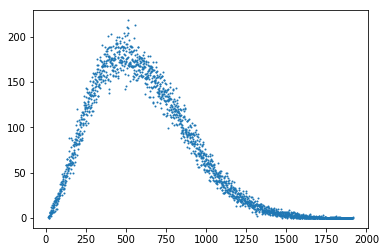



n_neighbors = 4 ------ eps = 9
noize/all = 0.327
under 20: 3148
under 50: 357
more 300: 16
bigest cluster: 72987
good clusters: 125


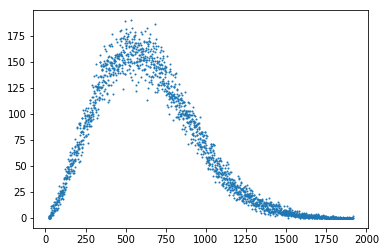



n_neighbors = 4 ------ eps = 10
noize/all = 0.278
under 20: 3071
under 50: 348
more 300: 12
bigest cluster: 84948
good clusters: 120


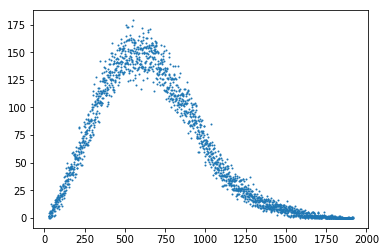



n_neighbors = 4 ------ eps = 11
noize/all = 0.237
under 20: 2888
under 50: 346
more 300: 10
bigest cluster: 95269
good clusters: 129


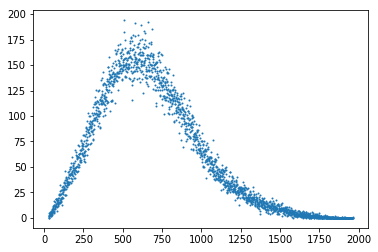



n_neighbors = 4 ------ eps = 12
noize/all = 0.202
under 20: 2664
under 50: 332
more 300: 13
bigest cluster: 103313
good clusters: 128


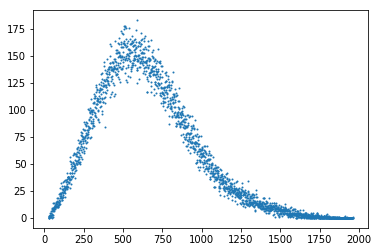



n_neighbors = 4 ------ eps = 13
noize/all = 0.171
under 20: 2410
under 50: 330
more 300: 7
bigest cluster: 113239
good clusters: 119


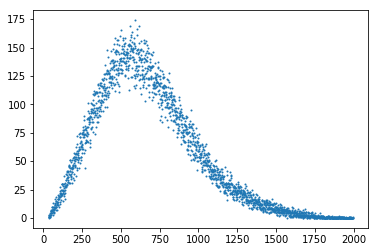



n_neighbors = 4 ------ eps = 14
noize/all = 0.143
under 20: 2153
under 50: 335
more 300: 8
bigest cluster: 122082
good clusters: 118


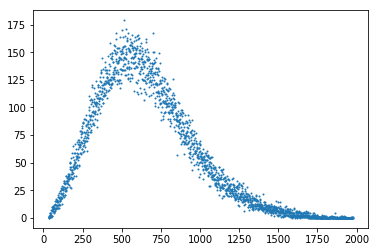



n_neighbors = 5 ------ eps = 3
noize/all = 0.810
under 20: 1619
under 50: 217
more 300: 10
bigest cluster: 932
good clusters: 103


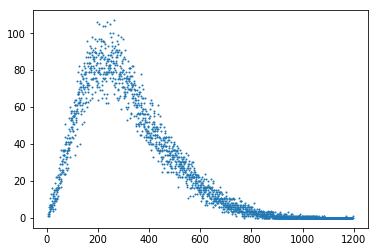



n_neighbors = 5 ------ eps = 4
noize/all = 0.715
under 20: 1831
under 50: 310
more 300: 18
bigest cluster: 3189
good clusters: 146


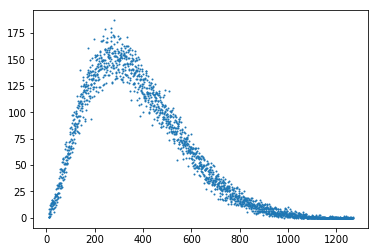



n_neighbors = 5 ------ eps = 5
noize/all = 0.633
under 20: 1901
under 50: 372
more 300: 28
bigest cluster: 9217
good clusters: 153


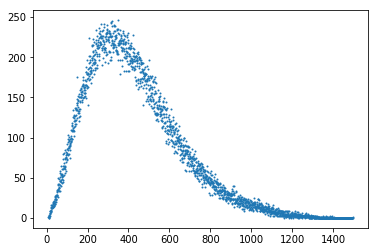



n_neighbors = 5 ------ eps = 6
noize/all = 0.559
under 20: 2009
under 50: 371
more 300: 19
bigest cluster: 18280
good clusters: 179


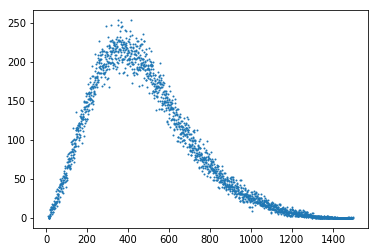



n_neighbors = 5 ------ eps = 7
noize/all = 0.493
under 20: 2076
under 50: 358
more 300: 22
bigest cluster: 27475
good clusters: 156


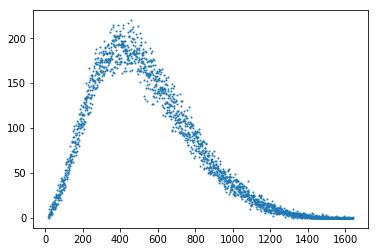



n_neighbors = 5 ------ eps = 8
noize/all = 0.432
under 20: 2171
under 50: 335
more 300: 19
bigest cluster: 44886
good clusters: 158


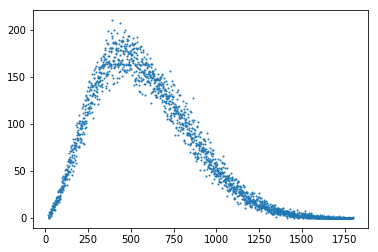



n_neighbors = 5 ------ eps = 9
noize/all = 0.375
under 20: 2206
under 50: 342
more 300: 16
bigest cluster: 61875
good clusters: 139


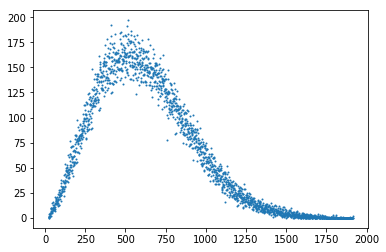



n_neighbors = 5 ------ eps = 10
noize/all = 0.324
under 20: 2187
under 50: 359
more 300: 13
bigest cluster: 79731
good clusters: 115


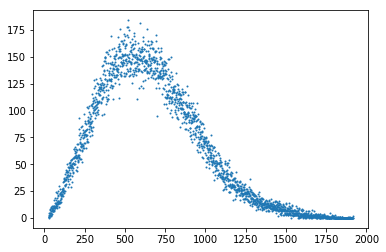



n_neighbors = 5 ------ eps = 11
noize/all = 0.281
under 20: 2110
under 50: 330
more 300: 11
bigest cluster: 90625
good clusters: 128


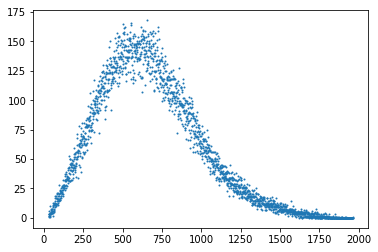



n_neighbors = 5 ------ eps = 12
noize/all = 0.243
under 20: 1948
under 50: 328
more 300: 14
bigest cluster: 98310
good clusters: 133


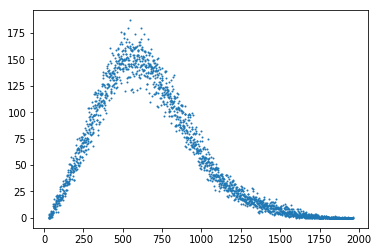



n_neighbors = 5 ------ eps = 13
noize/all = 0.208
under 20: 1829
under 50: 327
more 300: 14
bigest cluster: 105968
good clusters: 130


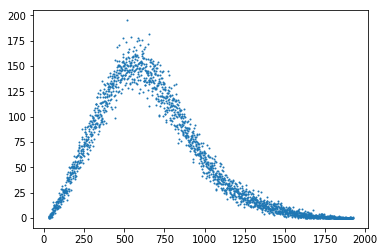



n_neighbors = 5 ------ eps = 14
noize/all = 0.177
under 20: 1666
under 50: 321
more 300: 8
bigest cluster: 116617
good clusters: 128


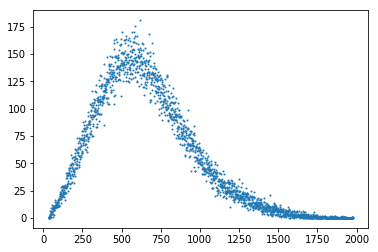



n_neighbors = 6 ------ eps = 3
noize/all = 0.838
under 20: 1161
under 50: 194
more 300: 10
bigest cluster: 885
good clusters: 97


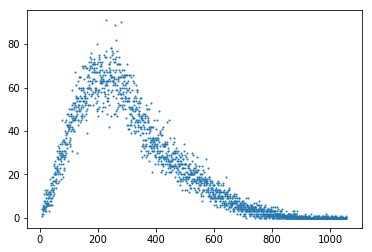



n_neighbors = 6 ------ eps = 4
noize/all = 0.747
under 20: 1320
under 50: 292
more 300: 15
bigest cluster: 3079
good clusters: 139


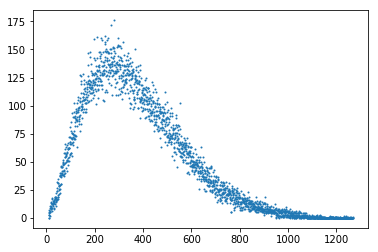



n_neighbors = 6 ------ eps = 5
noize/all = 0.666
under 20: 1392
under 50: 350
more 300: 27
bigest cluster: 9078
good clusters: 152


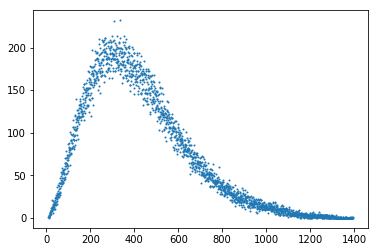



n_neighbors = 6 ------ eps = 6
noize/all = 0.596
under 20: 1414
under 50: 377
more 300: 21
bigest cluster: 15461
good clusters: 167


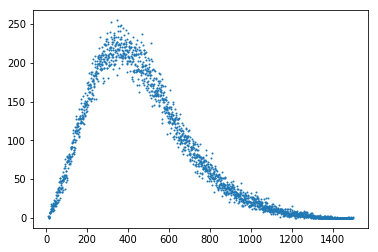



n_neighbors = 6 ------ eps = 7
noize/all = 0.532
under 20: 1452
under 50: 350
more 300: 17
bigest cluster: 26660
good clusters: 169


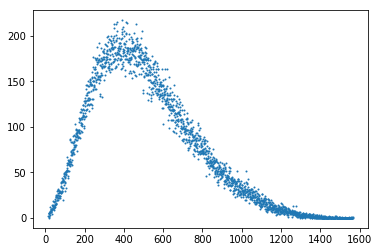



n_neighbors = 6 ------ eps = 8
noize/all = 0.472
under 20: 1545
under 50: 312
more 300: 23
bigest cluster: 32571
good clusters: 160


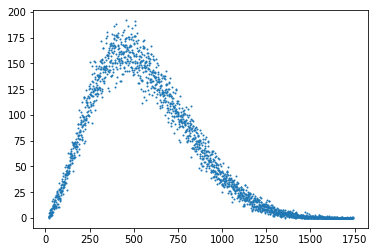



n_neighbors = 6 ------ eps = 9
noize/all = 0.417
under 20: 1554
under 50: 327
more 300: 13
bigest cluster: 59994
good clusters: 145


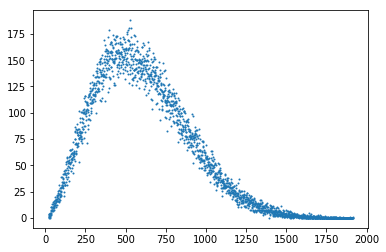



n_neighbors = 6 ------ eps = 10
noize/all = 0.364
under 20: 1577
under 50: 347
more 300: 18
bigest cluster: 74911
good clusters: 115


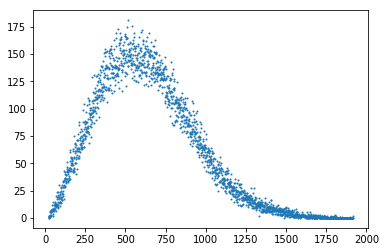



n_neighbors = 6 ------ eps = 11
noize/all = 0.318
under 20: 1543
under 50: 322
more 300: 15
bigest cluster: 83625
good clusters: 120


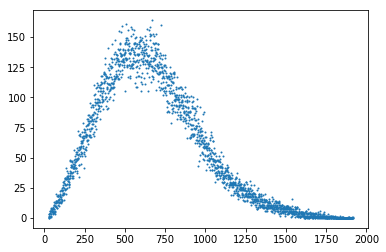



n_neighbors = 6 ------ eps = 12
noize/all = 0.279
under 20: 1499
under 50: 333
more 300: 10
bigest cluster: 96209
good clusters: 126


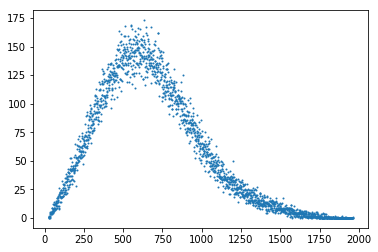



n_neighbors = 6 ------ eps = 13
noize/all = 0.241
under 20: 1439
under 50: 325
more 300: 13
bigest cluster: 102321
good clusters: 133


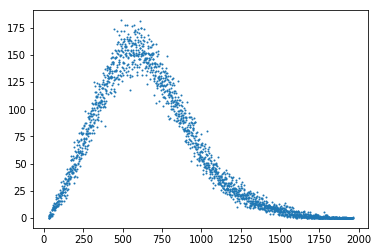



n_neighbors = 6 ------ eps = 14
noize/all = 0.208
under 20: 1352
under 50: 317
more 300: 13
bigest cluster: 109196
good clusters: 132


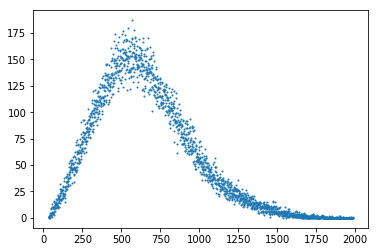



n_neighbors = 7 ------ eps = 3
noize/all = 0.862
under 20: 791
under 50: 176
more 300: 9
bigest cluster: 874
good clusters: 86


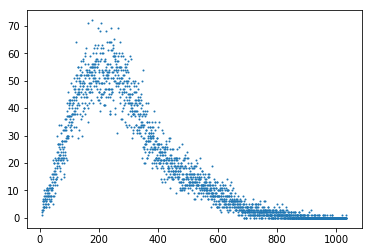



n_neighbors = 7 ------ eps = 4
noize/all = 0.774
under 20: 1010
under 50: 262
more 300: 15
bigest cluster: 2090
good clusters: 133


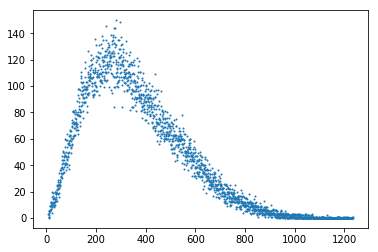



n_neighbors = 7 ------ eps = 5
noize/all = 0.694
under 20: 1062
under 50: 315
more 300: 24
bigest cluster: 5341
good clusters: 157


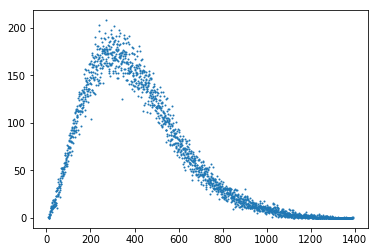



n_neighbors = 7 ------ eps = 6
noize/all = 0.626
under 20: 1027
under 50: 360
more 300: 24
bigest cluster: 14707
good clusters: 161


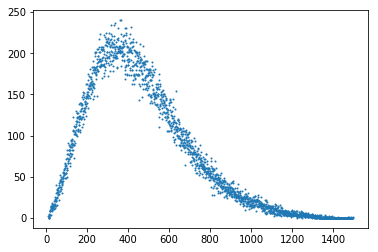



n_neighbors = 7 ------ eps = 7
noize/all = 0.563
under 20: 1076
under 50: 355
more 300: 19
bigest cluster: 22282
good clusters: 163


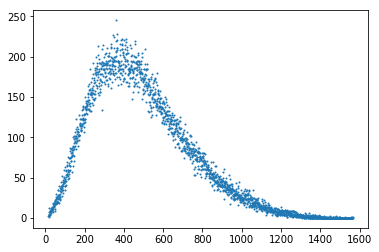



n_neighbors = 7 ------ eps = 8
noize/all = 0.505
under 20: 1114
under 50: 318
more 300: 23
bigest cluster: 30727
good clusters: 154


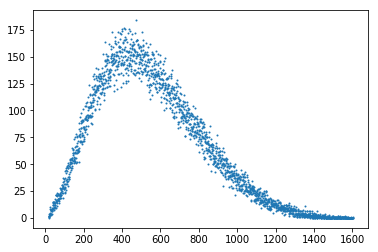



n_neighbors = 7 ------ eps = 9
noize/all = 0.450
under 20: 1182
under 50: 322
more 300: 18
bigest cluster: 57123
good clusters: 134


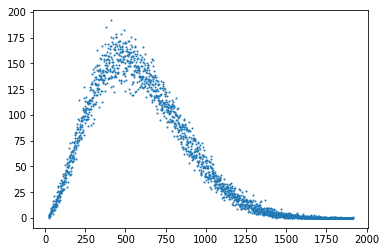



n_neighbors = 7 ------ eps = 10
noize/all = 0.400
under 20: 1145
under 50: 335
more 300: 18
bigest cluster: 69872
good clusters: 121


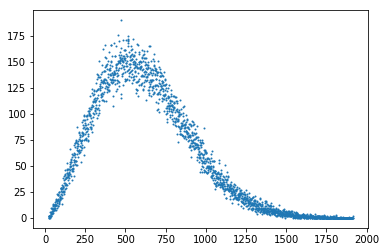



n_neighbors = 7 ------ eps = 11
noize/all = 0.352
under 20: 1161
under 50: 335
more 300: 13
bigest cluster: 80827
good clusters: 117


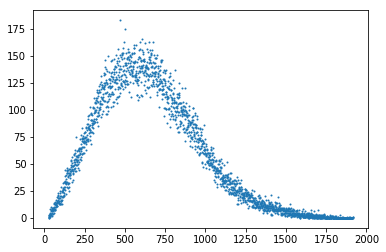



n_neighbors = 7 ------ eps = 12
noize/all = 0.311
under 20: 1171
under 50: 318
more 300: 12
bigest cluster: 91802
good clusters: 128


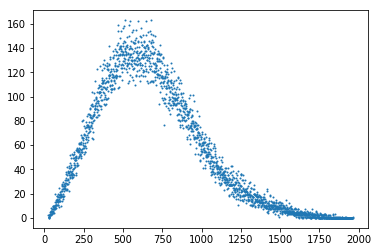



n_neighbors = 7 ------ eps = 13
noize/all = 0.273
under 20: 1117
under 50: 321
more 300: 12
bigest cluster: 98795
good clusters: 138


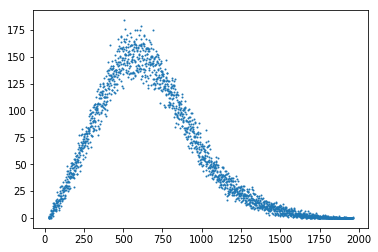



n_neighbors = 7 ------ eps = 14
noize/all = 0.236
under 20: 1092
under 50: 307
more 300: 13
bigest cluster: 104528
good clusters: 138


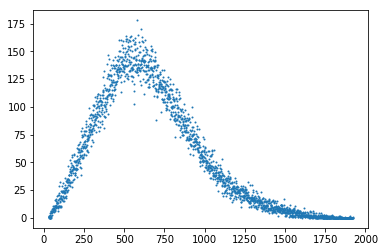



n_neighbors = 8 ------ eps = 3
noize/all = 0.882
under 20: 557
under 50: 168
more 300: 7
bigest cluster: 590
good clusters: 80


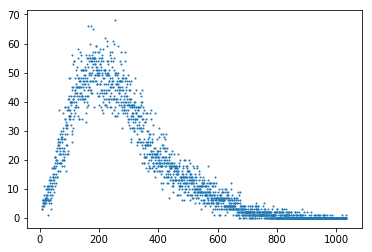



n_neighbors = 8 ------ eps = 4
noize/all = 0.798
under 20: 724
under 50: 253
more 300: 14
bigest cluster: 1444
good clusters: 130


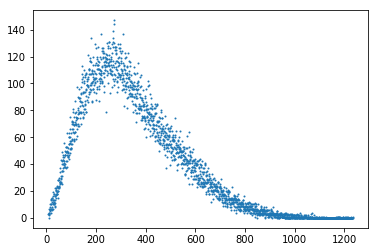



n_neighbors = 8 ------ eps = 5
noize/all = 0.721
under 20: 782
under 50: 302
more 300: 22
bigest cluster: 4692
good clusters: 154


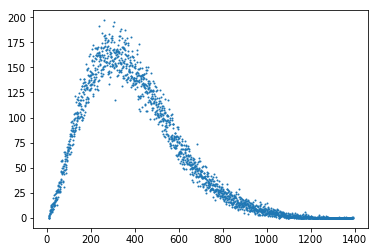



n_neighbors = 8 ------ eps = 6
noize/all = 0.650
under 20: 833
under 50: 338
more 300: 27
bigest cluster: 13838
good clusters: 164


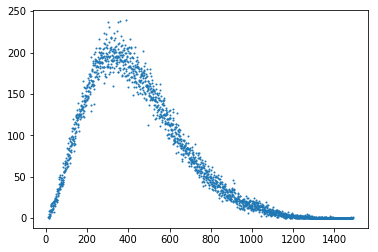



n_neighbors = 8 ------ eps = 7
noize/all = 0.590
under 20: 795
under 50: 362
more 300: 22
bigest cluster: 20101
good clusters: 157


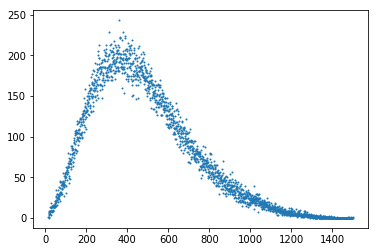



n_neighbors = 8 ------ eps = 8
noize/all = 0.532
under 20: 853
under 50: 325
more 300: 22
bigest cluster: 28998
good clusters: 154


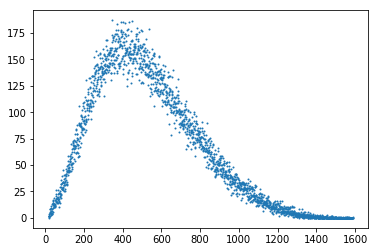



n_neighbors = 8 ------ eps = 9
noize/all = 0.479
under 20: 883
under 50: 304
more 300: 21
bigest cluster: 45265
good clusters: 144


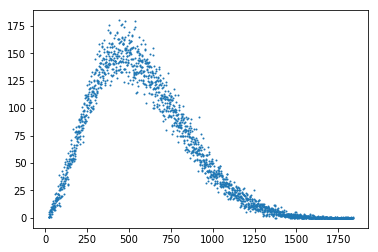



n_neighbors = 8 ------ eps = 10
noize/all = 0.430
under 20: 870
under 50: 319
more 300: 16
bigest cluster: 61956
good clusters: 133


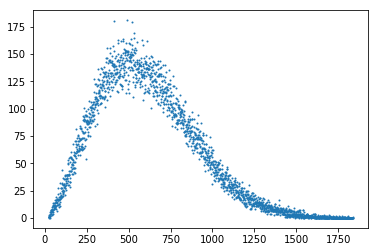



n_neighbors = 8 ------ eps = 11
noize/all = 0.383
under 20: 864
under 50: 347
more 300: 14
bigest cluster: 78386
good clusters: 113


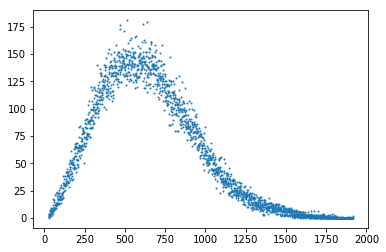



n_neighbors = 8 ------ eps = 12
noize/all = 0.341
under 20: 874
under 50: 328
more 300: 10
bigest cluster: 88377
good clusters: 125


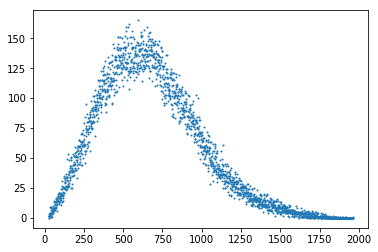



n_neighbors = 8 ------ eps = 13
noize/all = 0.302
under 20: 862
under 50: 319
more 300: 13
bigest cluster: 95843
good clusters: 130


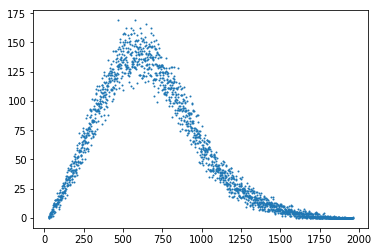



n_neighbors = 8 ------ eps = 14
noize/all = 0.265
under 20: 870
under 50: 316
more 300: 13
bigest cluster: 101482
good clusters: 129


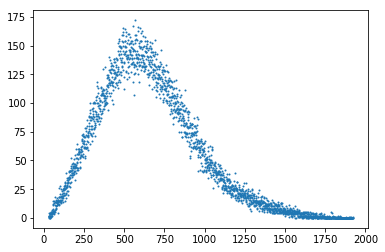



n_neighbors = 9 ------ eps = 3
noize/all = 0.897
under 20: 394
under 50: 172
more 300: 6
bigest cluster: 567
good clusters: 66


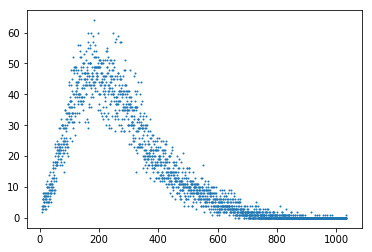



n_neighbors = 9 ------ eps = 4
noize/all = 0.819
under 20: 538
under 50: 249
more 300: 14
bigest cluster: 1422
good clusters: 115


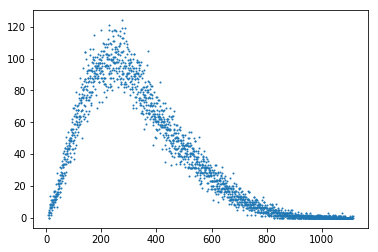



n_neighbors = 9 ------ eps = 5
noize/all = 0.743
under 20: 576
under 50: 307
more 300: 21
bigest cluster: 4649
good clusters: 147


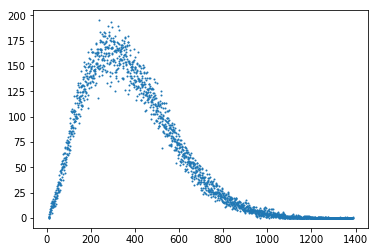



n_neighbors = 9 ------ eps = 6
noize/all = 0.674
under 20: 646
under 50: 330
more 300: 26
bigest cluster: 10835
good clusters: 162


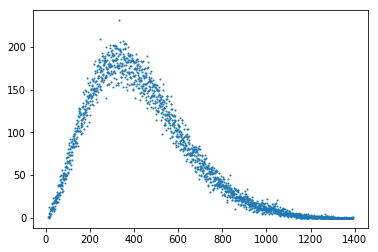



n_neighbors = 9 ------ eps = 7
noize/all = 0.613
under 20: 612
under 50: 355
more 300: 22
bigest cluster: 19385
good clusters: 165


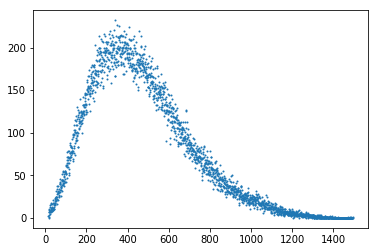



n_neighbors = 9 ------ eps = 8
noize/all = 0.556
under 20: 668
under 50: 306
more 300: 21
bigest cluster: 24775
good clusters: 162


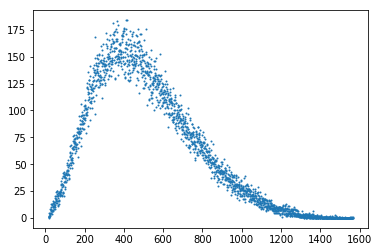



n_neighbors = 9 ------ eps = 9
noize/all = 0.504
under 20: 689
under 50: 306
more 300: 22
bigest cluster: 42923
good clusters: 146


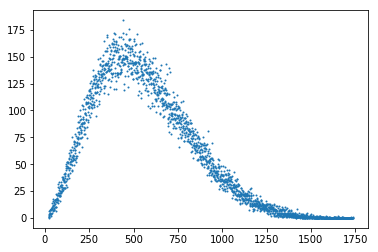



n_neighbors = 9 ------ eps = 10
noize/all = 0.455
under 20: 665
under 50: 318
more 300: 16
bigest cluster: 59233
good clusters: 135


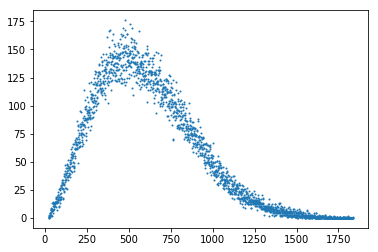



n_neighbors = 9 ------ eps = 11
noize/all = 0.409
under 20: 664
under 50: 339
more 300: 17
bigest cluster: 74294
good clusters: 119


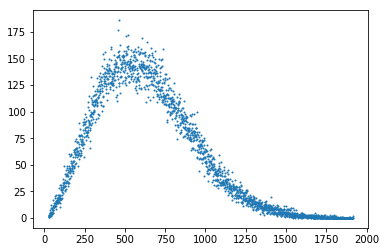



n_neighbors = 9 ------ eps = 12
noize/all = 0.368
under 20: 652
under 50: 321
more 300: 14
bigest cluster: 81358
good clusters: 126


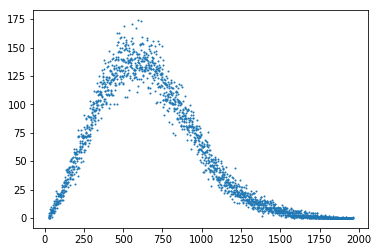



n_neighbors = 9 ------ eps = 13
noize/all = 0.328
under 20: 679
under 50: 317
more 300: 12
bigest cluster: 93084
good clusters: 127


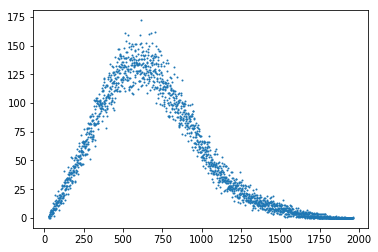



n_neighbors = 9 ------ eps = 14
noize/all = 0.292
under 20: 663
under 50: 310
more 300: 13
bigest cluster: 99156
good clusters: 128


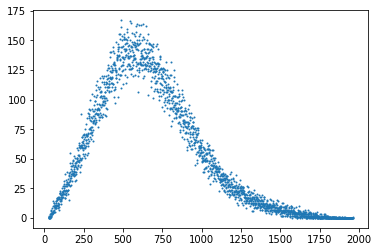

In [238]:
for n_neighbors in range(2, 10):
    for eps in range(3, 15):
        print('n_neighbors = {0} ------ eps = {1}'.format(n_neighbors, eps))
        res, lab, counts = do_scan_reg(points_xyz, eps, n_neighbors)
        plot_hist_dist(points_xyz, res, lab, counts)
        print('\n')

In [13]:
def plot_hist_dist(points_xyz, res, lab, counts, c_very_small=20):
    list_cens = list()
    for lab_ in lab:
        if lab_ == -1:
            continue
        if counts[lab_] < c_very_small:
            continue
        list_cens.append(points_xyz[res==lab_].mean(axis=0))

    all_clusters = np.array(list_cens)
    pair_dist_clusters = pairwise_distances(all_clusters)
    not_zero_pair = np.triu(pair_dist_clusters)
    not_zero_pair = not_zero_pair[not_zero_pair!=0]
    to_del = np.unique(np.argwhere((pair_dist_clusters < 2) & (pair_dist_clusters>0)).flatten())
    all_clusters = np.delete(all_clusters, to_del, 0)
    n1 = np.histogram(not_zero_pair, bins=500)
    plt.scatter(n1[1][1:], n1[0], s=1)
    plt.show()
    
    return all_clusters

In [221]:
list_cens = list()
j=0
for lab_ in lab:
    if lab_ == -1:
        continue
    if counts[lab_] < 10:
        j+=1
        continue
    list_cens.append(points_xyz[res==lab_].mean(axis=0))
print(len(list_cens))

all_clusters = np.array(list_cens)
pair_dist_clusters = pairwise_distances(all_clusters)
not_zero_pair = np.triu(pair_dist_clusters)
not_zero_pair = not_zero_pair[not_zero_pair!=0]
to_del = np.unique(np.argwhere((pair_dist_clusters < 2) & (pair_dist_clusters>0)).flatten())
all_clusters = np.delete(all_clusters, to_del, 0)
n1 = np.histogram(not_zero_pair, bins=1000)

plt.scatter(n1[1][1:], n1[0], s=1)

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


1358


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [132]:
%matplotlib notebook

noize/all = 0.381
under 20: 3225
under 50: 355
more 300: 19
bigest cluster: 54020
good clusters: 146


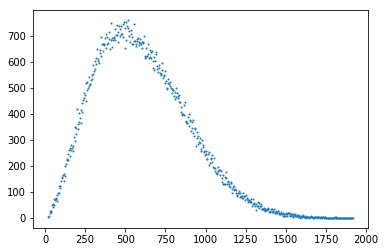

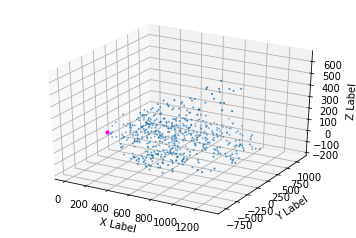

In [16]:
%matplotlib inline

res, lab, counts = do_scan_reg(points_xyz, 8, 4)
all_clusters = plot_hist_dist(points_xyz, res, lab, counts)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(*(all_clusters.T), s=1)
#ax.scatter(ar_show[:,:,0], ar_show[:,:,1], ar_show[:,:,2], s=10, c='red')
ax.scatter(0, 0, 0, s=10, c='magenta')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [161]:
%matplotlib

Using matplotlib backend: nbAgg


In [149]:
pair_dist_clusters = 0
not_zero_pair = 0

In [150]:
pair_dist_clusters = pairwise_distances(points_xyz[50000:65000,:])
not_zero_pair = np.triu(pair_dist_clusters)
not_zero_pair = not_zero_pair[not_zero_pair!=0]

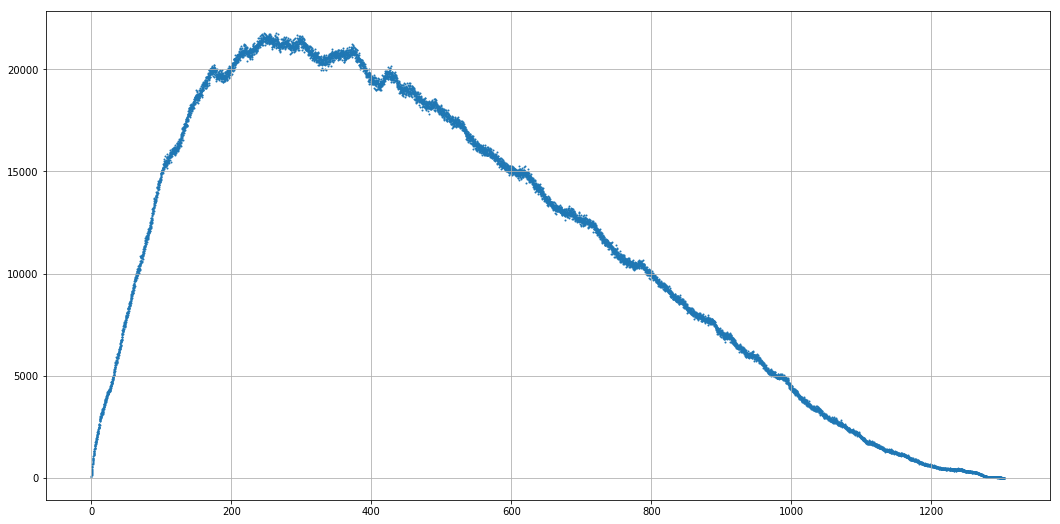

In [155]:
fig = plt.figure(figsize=(18, 9))
n1 = np.histogram(not_zero_pair, bins=10000)

plt.scatter(n1[1][1:], n1[0], s=1)

plt.grid(True)
plt.show()

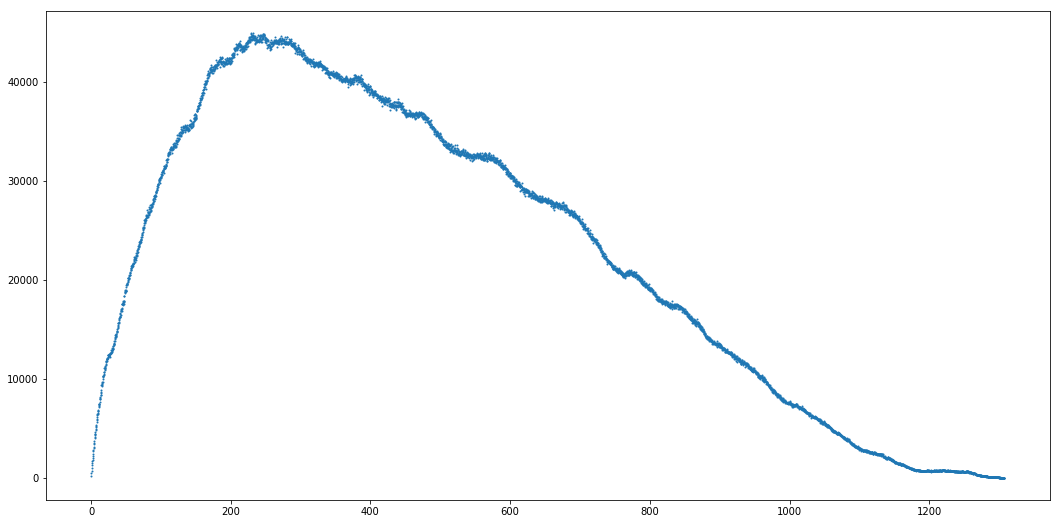

In [147]:
fig = plt.figure(figsize=(18, 9))
n1 = np.histogram(not_zero_pair, bins=5000)

plt.scatter(n1[1][1:], n1[0], s=1)

plt.show()

In [24]:
dist_avg = np.zeros_like(points_xyz[:,0])
dist_avg.shape

(191712,)

In [25]:
for i, point in enumerate(points_xyz):
    dist_avg[i] = np.linalg.norm(points_xyz-point, axis=1).mean()

In [17]:
point = points_xyz[0]

In [18]:
point

array([  5.37358017e+02,   5.27810496e-03,   3.76060941e+02])

In [23]:
np.linalg.norm(points_xyz-point, axis=1).mean()

544.82808774347598